In [13]:
import gtfs_functions as gtfs
import matplotlib
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import random
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# cluster visualizer
#%matplotlib inline
#from yellowbrick.cluster import KElbowVisualizer 

# sklearn kmeans
from sklearn.metrics.cluster import contingency_matrix

# pyclustering kmeans
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture


routes, stops, stop_times, trips, shapes = gtfs.import_gtfs("gtfs3Sept.zip")
stop_freq = gtfs.stops_freq(stop_times, stops)
line_freq = gtfs.lines_freq(stop_times, trips, shapes, routes)

Construction de la data pour l'arrêt 'HEROS' sur la ligne du 4, 92 etc...

In [2]:
StopIdExample = '5026'   #arrêt Heros sur la ligne du 4

TripsStoppingAtExample = stop_times[stop_times['stop_id']==StopIdExample]['trip_id'].unique()  #All the trip_id that are passing by StopIdExample

    #Here the .unique() command shows us only once a trip_id
    #Now we identify the (possibly) different route that are passing by 

RoutesContainingStopExample = [trips[trips['trip_id']==Trip]['route_id'].unique()[0] for Trip in TripsStoppingAtExample]
    #I transform it again in Data Frame so thta I can filter routes that appear twice or more
RoutesContainingStopExample = pd.DataFrame({'Routes':RoutesContainingStopExample})
RoutesContainingStopExample = RoutesContainingStopExample['Routes'].unique()

ServiceIdLigne4 = stop_times[(stop_times["stop_id"]==StopIdExample) 
                        & (stop_times["route_id"]=='10') 
                        & (stop_times['direction_id']==0)]['service_id'].unique() 

ScheduleExampleList = [stop_times[(stop_times["stop_id"]==StopIdExample) 
                        & (stop_times["route_id"]==route) 
                        & (stop_times['direction_id']==0)] for route in RoutesContainingStopExample]  

        #Here the only route RoutesContainingStopExample[0] is 67, and we only have one direction (don't know why)

ScheduleExampleList = [ScheduleExample[['arrival_time','departure_time']].sort_values('arrival_time') 
                        for ScheduleExample in ScheduleExampleList]

        #We delete other rows except 'arrival_time' and 'departure_time' and we sort them by earliness

IntervalTimeBetweenVehicleList=[]
for ScheduleExample in ScheduleExampleList:
        ArrivalTimeExample = ScheduleExample['arrival_time'].values                     #I turn these into arrays cause it's easier for me
        DepartureTimeExample = ScheduleExample['departure_time'].values                 #I don't know all the operations on a dataframe anyway

        IntervalTimeBetweenVehicle = ArrivalTimeExample[1:] - DepartureTimeExample[:-1]

                #Now put it back into a panda DataFrame
        
        IntervalTimeBetweenVehicle = pd.DataFrame({'StartOfWaiting':ArrivalTimeExample[1:],'TimeInterval':IntervalTimeBetweenVehicle})
        IntervalTimeBetweenVehicleList.append(IntervalTimeBetweenVehicle)

ArrivalTimeVehiclesVSList=[]
for ScheduleExample in ScheduleExampleList:
        ArrivalTimeExample = ScheduleExample['arrival_time'].values                     #I turn these into arrays cause it's easier for me
        DepartureTimeExample = ScheduleExample['departure_time'].values                 #I don't know all the operations on a dataframe anyway

        ArrivalTimeVehicles_i = ArrivalTimeExample[:-1] 
        ArrivalTimeVehicles_iplus1 = ArrivalTimeExample[1:] 

                #Now put it back into a panda DataFrame
        
        ArrivalTimeVehiclesVS = pd.DataFrame({'Vehicle_i':ArrivalTimeVehicles_i,'Vehicle_iPlus1':ArrivalTimeVehicles_iplus1})
        ArrivalTimeVehiclesVSList.append(ArrivalTimeVehiclesVS)

for i,IntervalTimeBetweenVehicle in enumerate(IntervalTimeBetweenVehicleList):
        IntervalTimeBetweenVehicle.mean()                                       #Takes the mean for each column, the mean over 'StartOfWaiting' is irrelevant
        MeanTimeIntervalExample = IntervalTimeBetweenVehicle.mean()[1]              

                #Now we can filter weird intervals

        IntervalTimeBetweenVehicleList[i]=IntervalTimeBetweenVehicle[IntervalTimeBetweenVehicle['TimeInterval']<3*MeanTimeIntervalExample]

On peut commencer le clustering

On test ici avec le K-MEANS

In [3]:
dataTestVS=ArrivalTimeVehiclesVSList[0]
dataTestInt = IntervalTimeBetweenVehicleList[0]
nCluster = 5
#Quick test
# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=nCluster, random_state=10)

# call fit method with data 
km = km_model.fit_predict(dataTestVS)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

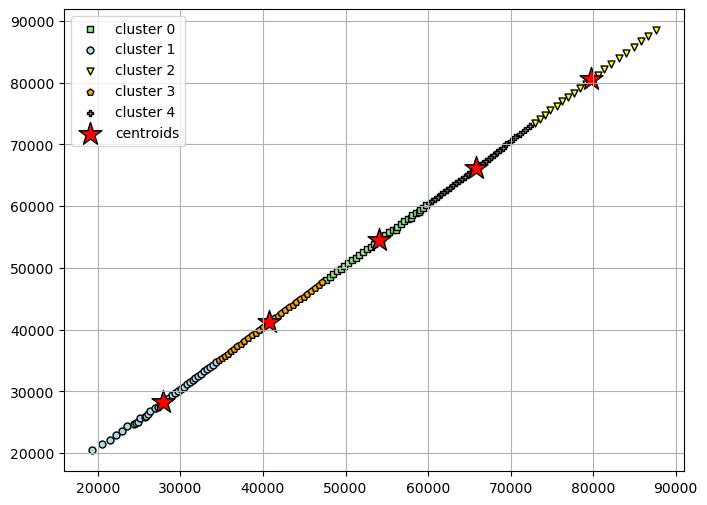

In [4]:
plt.figure(figsize=(8,6))
colors=['lightgreen','lightblue','yellow','orange','grey','violet']

markers=['s','o','v','p','P','x']

for n in range(nCluster):
    plt.scatter(
    dataTestVS[km == n]['Vehicle_i'], dataTestVS[km == n]['Vehicle_iPlus1'],
    s=25, c= colors[n],
    marker= markers[n], edgecolor='black',
    label='cluster '+str(n)
    )


# visualise centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

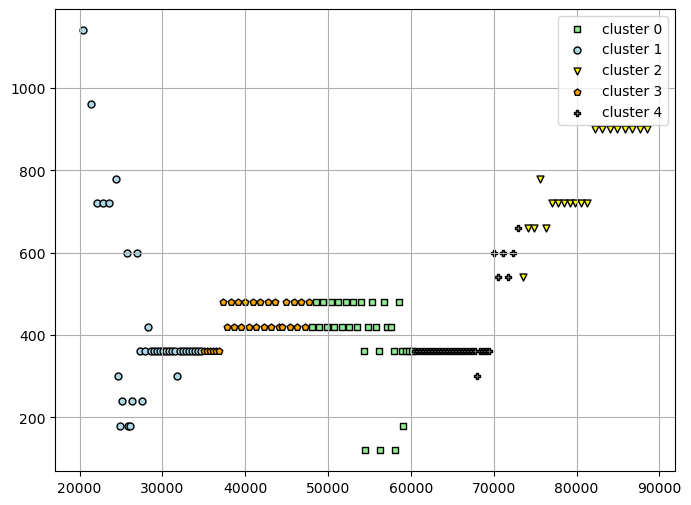

In [5]:
plt.figure(figsize=(8,6))
colors=['lightgreen','lightblue','yellow','orange','grey','violet']

markers=['s','o','v','p','P','x']

for n in range(nCluster):
    plt.scatter(
    dataTestInt[km == n]['StartOfWaiting'], dataTestInt[km == n]['TimeInterval'],
    s=25, c= colors[n],
    marker= markers[n], edgecolor='black',
    label='cluster '+str(n)
    )


# visualise centroids

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On test ici avec le DBSCAN

In [6]:
db = DBSCAN(eps=50000, min_samples=15).fit(dataTestVS)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

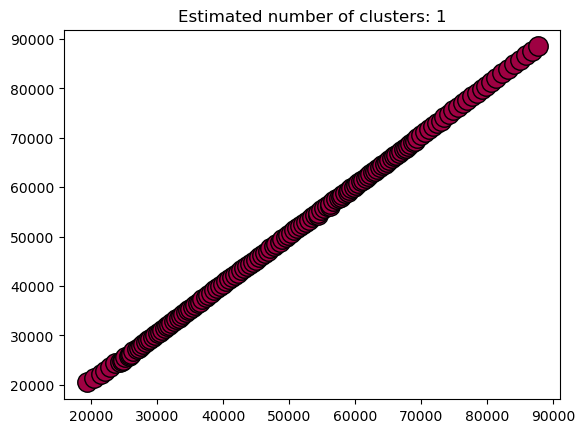

In [7]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colorsDBSCAN = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colorsDBSCAN):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = dataTestVS[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
    xy = dataTestVS[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Vraiment pas concluant vraiment dur de trouver les bons paramètres

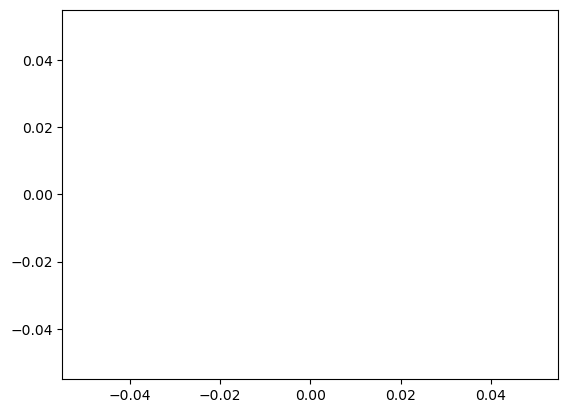

In [19]:
# initialize the data set we'll work with
training_data, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=4
)

# define the model
gaussian_model = GaussianMixture(n_components=2)

# train the model
gaussian_model.fit(training_data)

# assign each data point to a cluster
gaussian_result = gaussian_model.predict(training_data)


# get all of the unique clusters
gaussian_clusters = np.unique(gaussian_result)

# plot Gaussian Mixture the clusters
for gaussian_cluster in gaussian_clusters:
    # get data points that fall in this cluster
    index = np.where(gaussian_result == gaussian_clusters)
    # make the plot
    pyplot.plot(training_data[index, 0], training_data[index, 1],c='b')

# show the Gaussian Mixture plot
pyplot.show()

(array([], dtype=int64),)


TypeError: cannot do positional indexing on RangeIndex with these indexers [(array([], dtype=int64),)] of type tuple

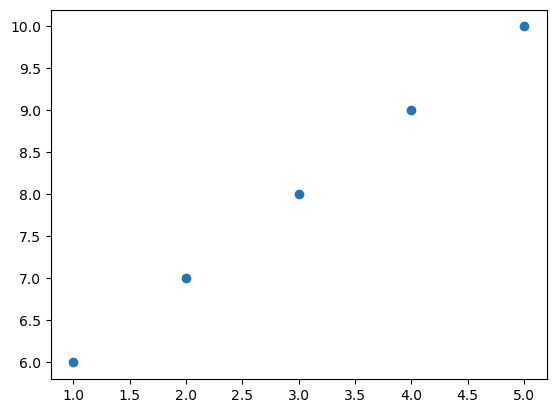

In [31]:
# initialize the data set we'll work with
import sklearn
from sklearn.datasets import make_classification
from sklearn.cluster import Birch

training_data, _ = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=4
)

# define the model
birch_model = Birch(threshold=0.03, n_clusters=4)

# train the model
birch_model.fit(dataTestVS)

# assign each data point to a cluster
birch_result = birch_model.predict(dataTestVS)

# get all of the unique clusters
birch_clusters = unique(birch_result)

# plot the BIRCH clusters
for birch_cluster in birch_clusters:
    # get data points that fall in this cluster
    index = where(birch_result == birch_clusters)
    print(index)
    # make the plot
    pyplot.scatter([1,2,3,4,5], [6,7,8,9,10])
    pyplot.scatter(dataTestVS.iloc[index:,0], dataTestVS.iloc[index:,1])

# show the BIRCH plot
pyplot.show()